# PS reconstruction, Gaussian beam

In [1]:
import torch
import numpy as np
from copy import deepcopy

import lightning as L
from cheetah.accelerator import Quadrupole, Drift
from cheetah import ParticleBeam

from gpsr.custom_cheetah.screen import Screen
from gpsr.diagnostics import ImageDiagnostic
from gpsr.datasets import SixDReconstructionDataset
from gpsr.modeling import GPSR6DLattice, GPSR
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6  # reference momentum in eV/c

gt_beam = torch.load("../example_data/example_distributions/gaussian_beam.pt")
gt_beam = ParticleBeam(gt_beam.particles, gt_beam.energy)

C:\Users\Ryan Roussel\AppData\Local\Temp\ipykernel_1828\625891174.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gt_beam = torch.load("../example_data/example_distribut

## Define diagnostics lattice parameters

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


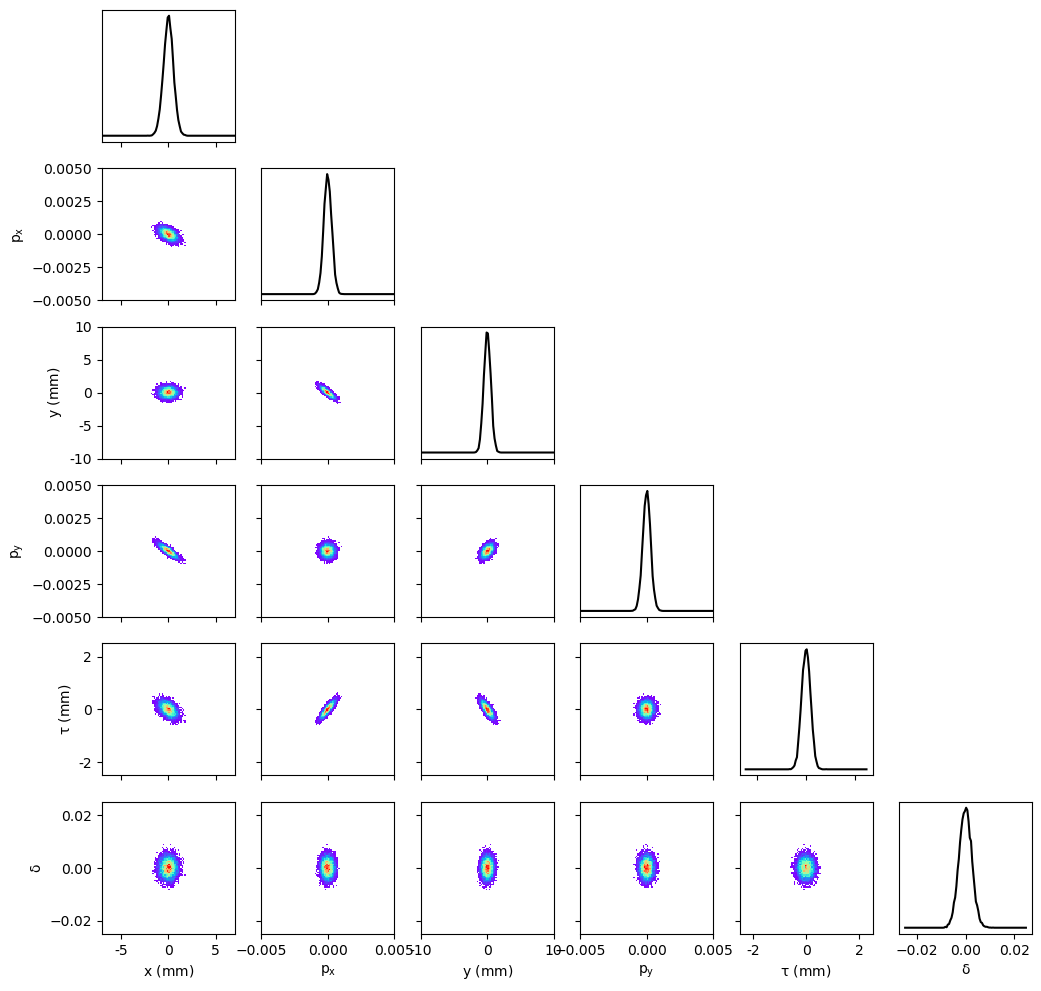

In [3]:
lims = [
    [-7e-3, 7e-3],
    [-5e-3, 5e-3],
    [-10e-3, 10e-3],
    [-5e-3, 5e-3],
    [-2.5e-3, 2.5e-3],
    [-2.5e-2, 2.5e-2],
]
gt_beam.plot_distribution(bin_ranges=lims);

In [4]:
# create diagnostic screens:
n_pixels = 200
pixel_size = torch.tensor(1e-3)
screen = Screen(
    resolution=(n_pixels, n_pixels),
    pixel_size=torch.tensor((pixel_size, pixel_size)),
    method="kde",
    kde_bandwidth=pixel_size / 2,
    is_active=True,
)

Cheetah based version

In [5]:
# define upstream beamline
k1 = torch.tensor(-24.868402)
k2 = torch.tensor(26.179029)
k3 = torch.tensor(-26.782126)

quad_length = torch.tensor(0.11)
lq12 = torch.tensor(1.209548)
lq23 = torch.tensor(0.19685)
lq34 = torch.tensor(0.18415)
ld1 = lq12 - quad_length
ld2 = lq23 - quad_length
ld3 = lq34 - quad_length
q1 = Quadrupole(length=quad_length, k1=k1, num_steps=5, tracking_method="bmadx")
d1 = Drift(ld1)
q2 = Quadrupole(length=quad_length, k1=k2, num_steps=5, tracking_method="bmadx")
d2 = Drift(ld2)
q3 = Quadrupole(length=quad_length, k1=k3, num_steps=5, tracking_method="bmadx")
d3 = Drift(ld3)
upstream_components = [q1, d1, q2, d2, q3, d3]

l_quad = 0.11
l_tdc = 0.01
f_tdc = 1.3e9
phi_tdc = 0.0
l_bend = 0.3018
theta_on = -20.0 * 3.14 / 180.0
l1 = 0.790702
l2 = 0.631698
l3 = 0.889

gpsr_lattice = GPSR6DLattice(
    l_quad,
    l_tdc,
    f_tdc,
    phi_tdc,
    l_bend,
    theta_on,
    l1,
    l2,
    l3,
    deepcopy(screen),
    deepcopy(screen),
    upstream_components,
)

In [6]:
# Scan over quad strength, tdc on/off and dipole on/off
n_ks = 5
PI = 3.14
ks = torch.linspace(-3, 3, n_ks)  # quad ks
vs = torch.tensor([0, 3e6])  # TDC off/on
gs = torch.tensor([-2.22e-16, -20.0 * PI / 180.0 / 0.365])  # dipole off/on

scan_ids = [6, 8, 10]
n_ks = 5

train_params = torch.meshgrid(gs, vs, ks, indexing="ij")
train_params = torch.stack(train_params, dim=-1)

# create training data
gpsr_lattice.set_lattice_parameters(train_params)
final_beam = gpsr_lattice.lattice(gt_beam)
obs = gpsr_lattice.track_and_observe(gt_beam)
obs_dataset = SixDReconstructionDataset(train_params, obs, screens=(screen, screen))

In [7]:
obs_dataset.observations[1].shape

torch.Size([2, 5, 200, 200])

In [8]:
torch.save(obs_dataset, "../example_data/example_datasets/reconstruction_6D.dset")

c:\ProgramData\mambaforge\envs\gpsr\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


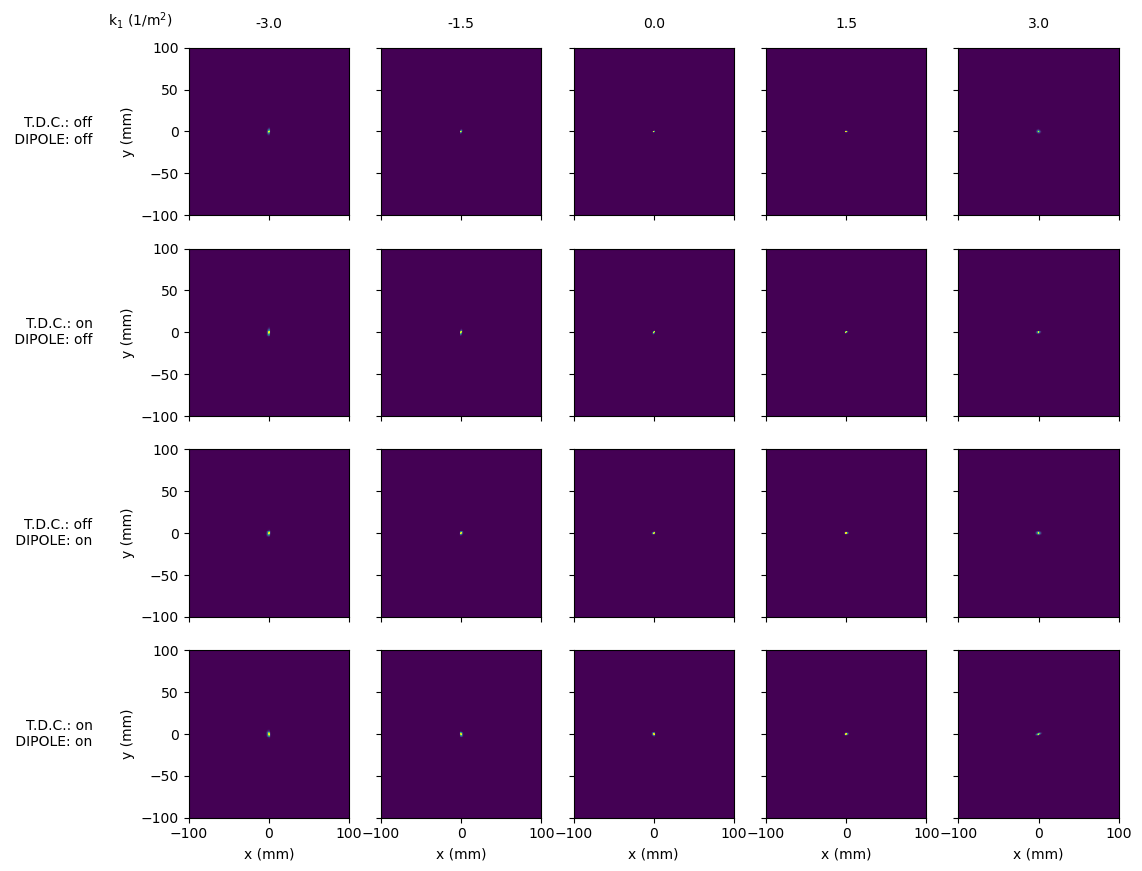

In [9]:
fig, ax = obs_dataset.plot_data()

## Training using pytorch lightning

In [10]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(obs_dataset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)
trainer = L.Trainer(limit_train_batches=100, max_epochs=500, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode
c:\ProgramData\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\ProgramData\mambaforge\envs\gpsr\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interv

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

In [ ]:
pred = tuple([ele.detach() for ele in gpsr_model(train_params)])
pred_dataset = SixDReconstructionDataset(train_params, pred, (bins, bins))
obs_dataset.plot_data(
    publication_size=True,
    overlay_data=pred_dataset,
    overlay_kwargs={"cmap": "Greys", "levels": [0.1, 0.5, 0.9]},
);

In [ ]:
from gpsr.visualization import compare_beams

compare_beams(gt_beam, reconstructed_beam, levels=[0.5, 0.75, 0.9]);